<a href="https://colab.research.google.com/github/HendrikBlomberg/Test-Repo/blob/master/VV_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Notebook for creating forecasts for VV materials based on historic consumption**

Import libraries

In [934]:
# import pandas as pd
# import numpy as np
# import math
# import matplotlib.pyplot as plt 

Read the raw data file

In [935]:
# file = "VV_Material_8200_Consumption_2018-2021_2.XLSX"
# names = ["Material", "Plant", "Year", "Period", "Quarter", "1","2","3","4","5","6","7","8","9","10","11","12","13"]

# df0 = pd.read_excel(file, names=names)
# df0.head()

Create a copy of the original df

In [936]:
# df will be used for transformation
df = df0.copy()

### Drop columns "Period" and "Plant" - for future use, dont include that columns in the df at all by filtering the sap quickview appropiately
df = df.drop(["Plant","Period"],1)

Create fake df

If there has been no consumption during a quarter, this quarter will not show up in the original df. We need this quarter to show up with zero consumption to have complete time series. First we create a fake df that holds all years and quarters from 2018 - today by material. Then we merge this df with our dataframe and we take the real consumption values for weeks where we have data. For weeks without data, we fill the columns with zeros.

In [937]:
# create arrays used to construct the dataframe
material = np.repeat(df.Material.unique(), (len(df.Year.unique()) *len(df.Quarter.unique())))
quarter =list(range(1,6)) * len(df.Year.unique()) *len(df.Material.unique())
year = np.tile(np.repeat(df.Year.unique(),len(df.Quarter.unique())),len(df.Material.unique()))

# create the dataframe
data_df1 = {
            "Material" : material,
            "Year"  : year,
            "Quarter" : quarter
            }
df1 = pd.DataFrame(data_df1)

Process the dataframe for analysis

In [938]:
# merge the original df and the fake df to get df with all years, weeks and quarters for all material
df = pd.merge(df1, df.drop_duplicates(subset=["Material", "Year", "Quarter"]), how = "left", on = ["Material", "Year", "Quarter"]).fillna(0)

# reshape the df from wide to long (tabular)
df = pd.melt(df, id_vars=["Material","Year","Quarter"], var_name="Week", value_name="Consumption")
df["Week"] = df["Week"].astype(int)
df = df.sort_values(by=["Material", "Year", "Quarter", "Week"]).reset_index(drop=True)

# remove all rows for quarter 5 and week not equal to 1 (weeks 54+) and year not equal to 2020 (leap year)
# those are not real weeks, generated by sap's way of storing the data
df = df[~((df['Year'] != 2020) & (df['Quarter'] == 5))]
df = df[~((df['Quarter'] == 5) & (df['Week'] != 1))]

# create a new df that holds all periods connected to quarters and weeks from the original df
q = np.repeat([1,2,3,4],13)
w = np.tile([1,2,3,4,5,6,7,8,9,10,11,12,13],4)
p = list(range(1,53))

data = {'Quarter': q,
        'Week': w,
        'Period':p}
period_df = pd.DataFrame.from_dict(data)

# merge the original df and the period df
df = df.merge(period_df, how = "left", on = ["Quarter", "Week"])
# fill the na values with 53
# na values are all period 53 from year 2020
df["Period"].fillna(53, inplace = True)

# remove rows containing data for future weeks, sort the df
df.Period = df.Period.astype(int)
df["Period"] = df.Period.map("{:02}".format) # change format to leading zero / two character
df["Period"] = df["Period"] + "." + df["Year"].astype(str)
df["period_sort"] = df["Period"].str[3:] + "." + df["Period"].str[:2] # create new column period_sort that reverses period
df = df.loc[df["period_sort"]<="2021.14"] # remove everything after 2021 week xx -> variable to be added
df = df.sort_values(by=["Material","period_sort"], ascending=[True,False])

Identify High-Runners

In [939]:
# Show the number of hits (consumption > 0) in a given year by material
# df[(df['Consumption'] > 0) & (df["Year"]==2020)].groupby('Material')['Consumption'].count().sort_values(ascending=False)

Calculate Mean and MAD using Moving Average (as we do it in SAP)

In [948]:
# select the material
check_material = 2567
# inclusive - select upper end of weeks to include (0 = current week)   
a = 0
# exclusive - select lower end of weeks to include                  
b = 52                 

df_ = df.loc[df["Material"]==check_material].reset_index(drop=True)
calculated_mean = str(round(df_.Consumption[a:b].mean(),3))
calculated_mad = str(round(df_.Consumption[a:b].mad(),3))

print(list(df_.Consumption[a:b]))
print("\nMean: " +  calculated_mean)
print("MAD: " + calculated_mad)

[762.0, 246.0, 420.0, 570.0, 474.0, 1350.0, 312.0, 648.0, 804.0, 1002.0, 558.0, 330.0, 492.0, 420.0, 0.0, 60.0, 498.0, 336.0, 378.0, 1074.0, 1134.0, 1548.0, 540.0, 978.0, 984.0, 384.0, 1764.0, 510.0, 180.0, 1164.0, 1026.0, 264.0, 510.0, 1530.0, 594.0, 894.0, 3210.0, 0.0, 0.0, 162.0, 150.0, 222.0, 330.0, 996.0, 912.0, 0.0, 0.0, 72.0, 492.0, 1188.0, 984.0, 252.0]

Mean: 648.231
MAD: 422.601


Plot Consumption by Week

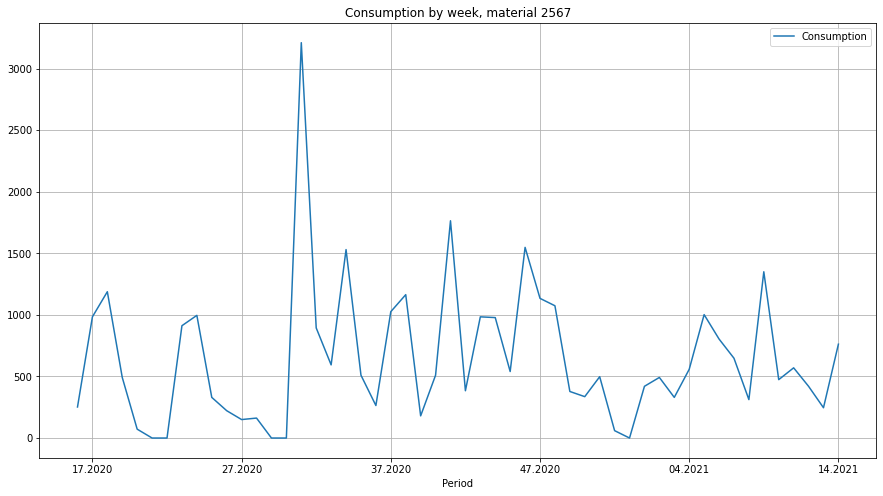

In [949]:
# use the same input from the mean and mad calculation before
df_[a:b].plot(x="Period", y="Consumption", figsize =(15,8), grid = True, title = "Consumption by week, material " + str(check_material))
plt.gca().invert_xaxis()
plt.show()